In [1]:
# notebook to elucidate the secrets of the simple reactor solver
# (and maybe compare results to Cantera)

# now trying to extract sensitivities from simple solver

In [2]:
import rmgpy.chemkin
import os

import cantera as ct
import numpy as np
import logging

import rmgpy.solver  # import SimpleReactor, TerminationTime, SurfaceReactor
import rmgpy.quantity  #import Quantity
import rmgpy.rmg.listener # import SimulationProfileWriter, SimulationProfilePlotter
import rmgpy.rmg.settings  #import ModelSettings, SimulatorSettings
import rmgpy.util
import rmgpy.tools.plot

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig(level=logging.DEBUG)



In [3]:
sevy_mech = '/home/moon/rmg/RMG-Py/examples/rmg/superminimal/chemkin'
s_chemkin = os.path.join(sevy_mech, 'chem_annotated.inp')
s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(s_chemkin, s_dict)

output_directory = 'simple_csvs'

os.makedirs(output_directory, exist_ok=True)

INFO:root:Thermo file has default temperature range 300.0 to 1000.0 and 1000.0 to 5000.0


# Cantera version

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Source Code Pro' (SourceCodePro-SemiboldIt.ttf) italic normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Source Code Pro' (SourceCodePro-BoldIt.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Source Code Pro' (SourceCodePro-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-BI.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Source Code Pro' (SourceCodePro-It.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Source Code Pro' (SourceCodePro-BlackIt.ttf) italic normal 900 normal>) 

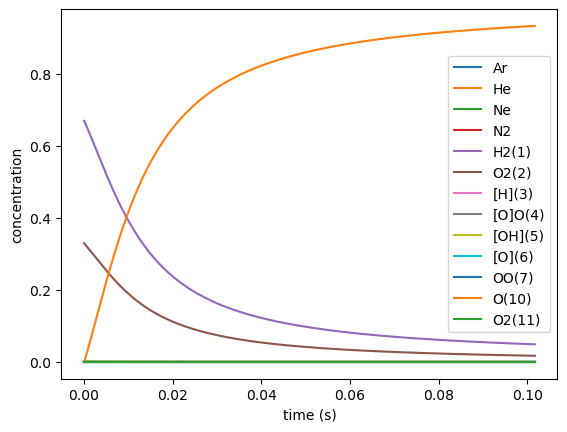

In [5]:
gas = ct.Solution('/home/moon/rmg/RMG-Py/examples/rmg/superminimal/cantera/chem_annotated.yaml')

T = 1500.0
P = 100000.0
initial_mole_fractions='H2(1):0.67, O2(2):0.33'
gas.TPX = T, P, initial_mole_fractions





reactor = ct.IdealGasConstPressureReactor(gas, energy='off')  # isothermal
net = ct.ReactorNet([reactor])


# set the tolerances for the solution and for the sensitivity coefficients
net.rtol = 1.0e-6
net.atol = 1.0e-15
net.rtol_sensitivity = 1.0e-6
net.atol_sensitivity = 1.0e-6


# find out what is the most sensitive parameter to the H2 concentration
for i in range(gas.n_reactions):
    reactor.add_sensitivity_reaction(i)


ts_ct = [net.time]
ys_ct = [reactor.thermo.X]
senss = [np.zeros(gas.n_reactions)]

while net.time < 1e-1:
    net.step()
    ts_ct.append(net.time)
    ys_ct.append(reactor.thermo.X)
    sens_mat = np.zeros(gas.n_reactions)
    for i in range(gas.n_reactions):
        sens_mat[i] = net.sensitivity('H2(1)', i)
    senss.append(sens_mat)

# plot results
for i in range(len(ys_ct[0])):
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, label=gas.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

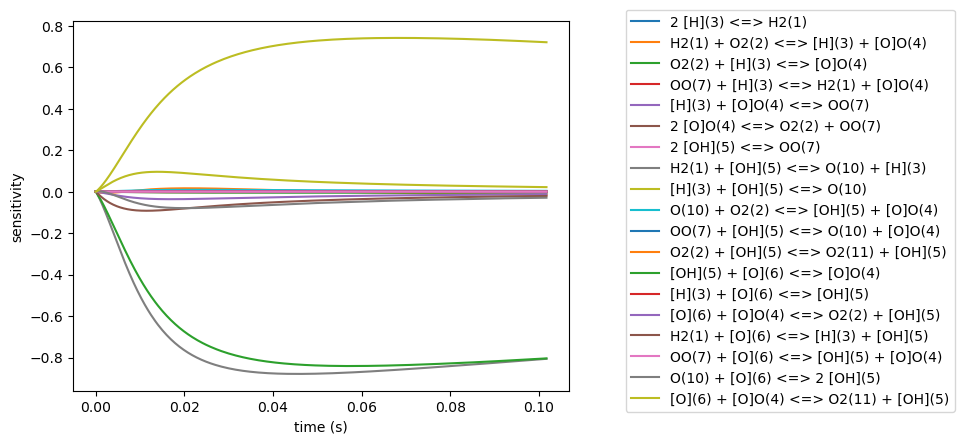

In [7]:
# plot sensitivity results
for i in range(len(senss[0])):
    y_hs = [x[i] for x in senss]
    plt.plot(ts_ct, y_hs, label=gas.reaction_equations()[i])
plt.xlabel('time (s)')
plt.ylabel('sensitivity')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [32]:
gas.reaction_equations

<function Solution.reaction_equations>

In [33]:
senss

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([-1.39418131e-19, -7.16470108e-15,  3.44068043e-35, -4.08495482e-28,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.47916340e-47,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([-6.19731703e-17, -3.18480270e-12,  3.00030797e-27, -1.62512637e-22,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.58871052e-37,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([-2.55680999e-16, -1.31394526e-11, -7.09661340e-25, -1.73107155e-21,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,

In [ ]:
# can we repeat with species?

gas = ct.Solution('/home/moon/rmg/RMG-Py/examples/rmg/superminimal/cantera/chem_annotated.yaml')

T = 1500.0
P = 100000.0
initial_mole_fractions='H2(1):0.67, O2(2):0.33'
gas.TPX = T, P, initial_mole_fractions





reactor = ct.IdealGasConstPressureReactor(gas, energy='off')  # isothermal
net = ct.ReactorNet([reactor])


# set the tolerances for the solution and for the sensitivity coefficients
net.rtol = 1.0e-6
net.atol = 1.0e-15
net.rtol_sensitivity = 1.0e-6
net.atol_sensitivity = 1.0e-6


# find out what is the most sensitive parameter to the H2 concentration
for i in range(gas.n_reactions):
    reactor.add_sensitivity_reaction(i)


ts_ct = [net.time]
ys_ct = [reactor.thermo.X]
senss = [np.zeros(gas.n_reactions)]

while net.time < 1e-1:
    net.step()
    ts_ct.append(net.time)
    ys_ct.append(reactor.thermo.X)
    sens_mat = np.zeros(gas.n_reactions)
    for i in range(gas.n_reactions):
        sens_mat[i] = net.sensitivity('H2(1)', i)
    senss.append(sens_mat)

# plot results
for i in range(len(ys_ct[0])):
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, label=gas.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

In [13]:
net.sensitivity_parameter_name(4)

'IdealGasConstPressureReactor_1: [H](3) + [O]O(4) <=> OO(7)'

In [8]:
net.get_state()

array([9.54967310e-02, 1.50000000e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.64503657e-03, 3.13039153e-02,
       1.43645872e-07, 1.51547325e-05, 7.51937689e-05, 4.25025993e-07,
       1.32545022e-08, 9.62943816e-01, 1.63016658e-05])

In [29]:
len(ts_ct)

578

In [30]:
len(reaction_list)

19

# RMG simple.pyx

In [67]:
T = (1500, 'K')
P = (1, 'bar')
termination_time = (1.0e-1, 's')
termination = [rmgpy.solver.TerminationTime(rmgpy.quantity.Quantity(termination_time))]
sensitivity_threshold=1e-3

# display(species_list[4], species_list[5])
initial_mole_fractions={
    species_list[4]: 0.67,  # H2
    species_list[5]: 0.33,  # O2
}
sensitive_species = [species_list[4]]
# sensitive_species = []


reaction_system = rmgpy.solver.SimpleReactor(
    T=T,
    P=P,
    initial_mole_fractions=initial_mole_fractions,
    termination=termination,
    sensitive_species=sensitive_species,
    sensitivity_threshold=sensitivity_threshold
)


reaction_system.initialize_model(
    species_list,
    reaction_list,
    [],
    [],
)

DEBUG:root:Initializing surface...
DEBUG:root:Surface initialization complete


In [70]:
# Create the csv worksheets for logging sensitivity
output_directory = 'sensitivity_calcs'
os.makedirs(output_directory, exist_ok=True)
rmgpy.util.make_output_subdirectory(output_directory, 'solver')
sens_worksheet = []
reaction_system_index = 0
for spec in reaction_system.sensitive_species:
    csvfile_path = os.path.join(output_directory, 'solver',
                                'sensitivity_{0}_SPC_{1}.csv'.format(reaction_system_index + 1, spec.index))
    sens_worksheet.append(csvfile_path)

reaction_system.attach(rmgpy.rmg.listener.SimulationProfileWriter(
    output_directory, reaction_system_index, species_list))
reaction_system.attach(rmgpy.rmg.listener.SimulationProfilePlotter(
    output_directory, reaction_system_index, species_list))

simulator_settings = rmgpy.rmg.settings.SimulatorSettings()  # defaults

model_settings = rmgpy.rmg.settings.ModelSettings()  # defaults
model_settings.tol_move_to_core = 0.1
model_settings.tol_interrupt_simulation = 1.0
model_settings.tol_keep_in_edge = 0.0

print('starting simulation')
reaction_system.simulate(
    core_species=species_list,
    core_reactions=reaction_list,
    edge_species=[],
    edge_reactions=[],
    surface_species=[x for x in species_list if x.contains_surface_site()],
    surface_reactions=[x for x in reaction_list if x.is_surface_reaction()],
    model_settings=model_settings,
    simulator_settings=simulator_settings,
    sensitivity=True,
    sens_worksheet=sens_worksheet,
)

DEBUG:root:Initializing surface...
DEBUG:root:Surface initialization complete


starting simulation


INFO:root:At time 1.0000e-01 s, reached target termination time.


(True, False, [], [], [], 0.10053813816348887, 0.0)

In [73]:
reaction_system_index = 0
for sens_species in sensitive_species:
    csvfile_path = os.path.join(output_directory, 'solver',
                                'sensitivity_{0}_SPC_{1}.csv'.format(reaction_system_index+1,
                                                                     sens_species.index))
    time, data_list = rmgpy.tools.plot.parse_csv_data(csvfile_path)

In [78]:
times = time.data

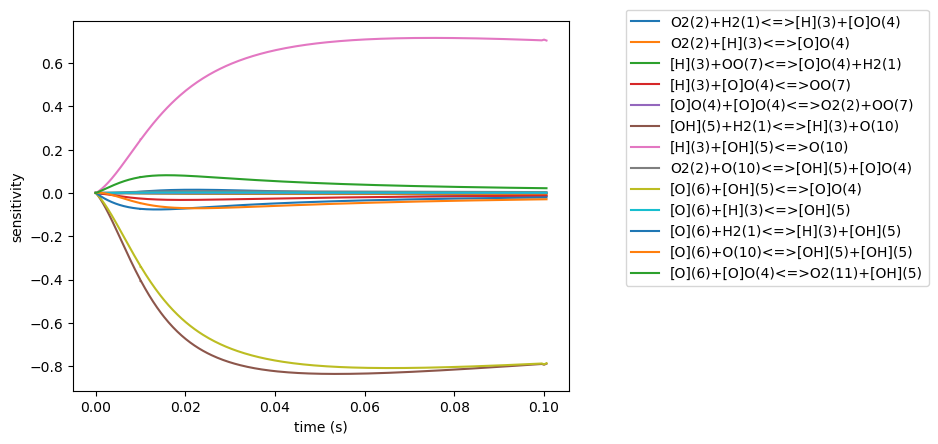

In [85]:
for data in data_list:
    if 'dG' in data.label:
        continue
#     print(data.label)

    plt.plot(times, data.data, label=data.label.split()[-1])
plt.xlabel('time (s)')
plt.ylabel('sensitivity')
plt.legend(bbox_to_anchor=(1.1, 1.05))

732

In [52]:

# Options controlling the ODE simulations:
initial_time = 1e-12  # The time at which to initiate the simulation, in seconds
time_step = 10 ** 0.1  # The multiplicative factor to use between consecutive time points
time_step = 10 ** 0.05  # The multiplicative factor to use between consecutive time points
abs_tol = 1e-16  # The absolute tolerance to use in the ODE simluations
rel_tol = 1e-8  # The relative tolerance to use in the ODE simulations

terminated = False
next_time = initial_time
step_time = initial_time

times = [reaction_system.t]
# ys = [reaction_system.y]
ys = [reaction_system.core_species_concentrations]
ddts = [reaction_system.compute_rate_derivative()]


while reaction_system.t < termination_time[0]:
    # Integrate forward in time to the next time point
    reaction_system.step(step_time)

    if reaction_system.t >= 0.9999 * next_time:
        next_time *= time_step
        times.append(reaction_system.t)
        ys.append(reaction_system.core_species_concentrations)
        
        norm_sens[j] = 1/volume * (mole_sens[j*num_core_species+sens_species_indices[i]]-c*dVdk[j]) * forward_rate_coefficients[j]/c
        ddts.append(reaction_system.compute_rate_derivative())
#         ys.append(reaction_system.y)

    # Increment destination step time if necessary
    if reaction_system.t >= 0.9999 * step_time:
        step_time *= 10.0

In [54]:
len(ddts)

222

In [57]:
ddts[0].shape

(13, 32)

In [55]:
len(times)

222

In [58]:
species_list[4]

In [62]:
reaction_system.V

0.08503784494330646

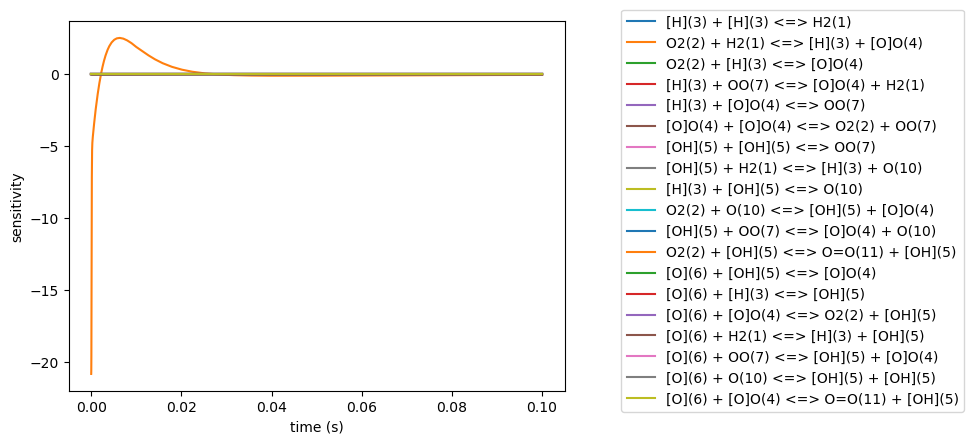

In [65]:
for i in range(len(reaction_list)):
    y_hs = [x[4, i] / reaction_system.V for x in ddts]  #it's reactions first, then spec
    plt.plot(times, y_hs, label=str(reaction_list[i]))
plt.xlabel('time (s)')
plt.ylabel('sensitivity')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:

        # Create the csv worksheets for logging sensitivity
        util.make_output_subdirectory(self.output_directory, 'solver')
        sens_worksheet = []
        reaction_system_index = 0
        for spec in reaction_system.sensitive_species:
            csvfile_path = os.path.join(self.output_directory, 'solver',
                                        'sensitivity_{0}_SPC_{1}.csv'.format(reaction_system_index + 1, spec.index))
            sens_worksheet.append(csvfile_path)

        reaction_system.attach(SimulationProfileWriter(
            self.output_directory, reaction_system_index, self.species_list))
        reaction_system.attach(SimulationProfilePlotter(
            self.output_directory, reaction_system_index, self.species_list))

        simulator_settings = SimulatorSettings()  # defaults

        model_settings = ModelSettings()  # defaults
        model_settings.tol_move_to_core = 0.1
        model_settings.tol_interrupt_simulation = 1.0
        model_settings.tol_keep_in_edge = 0.0

        print('starting simulation')
        reaction_system.simulate(
            core_species=self.species_list,
            core_reactions=self.reaction_list,
            edge_species=[],
            edge_reactions=[],
            surface_species=[x for x in self.species_list if x.contains_surface_site()],
            surface_reactions=[x for x in self.reaction_list if x.is_surface_reaction()],
            model_settings=model_settings,
            simulator_settings=simulator_settings,
            sensitivity=True,
            sens_worksheet=sens_worksheet,
        )

In [40]:
reaction_system.compute_rate_derivative().shape

(13, 32)

In [41]:
len(reaction_list)

19

In [42]:
len(species_list)

13

In [44]:
species_list[4]

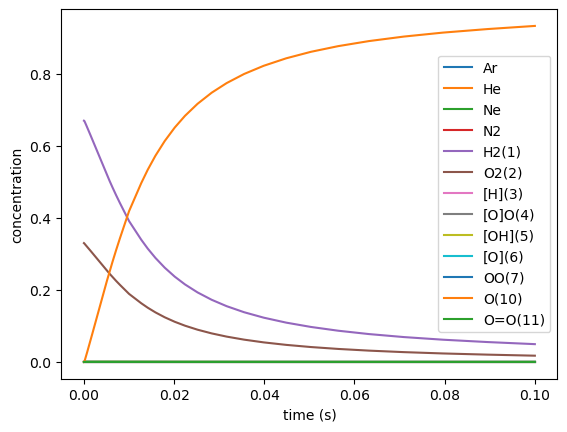

In [38]:
for i in range(len(ys[0])):
    y_hs = [x[i] for x in ys]
    plt.plot(times, y_hs / np.sum(ys[0]), label=str(species_list[i]))
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

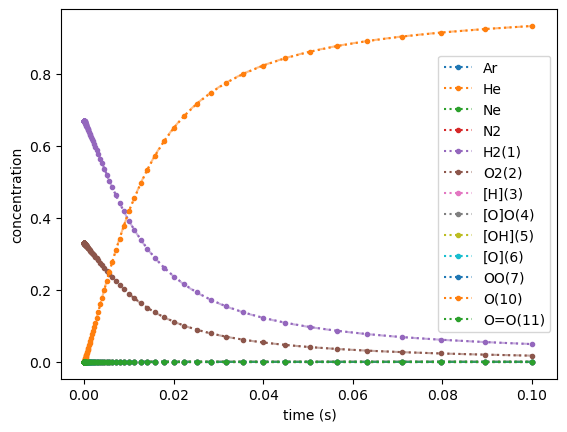

In [7]:
# plot on top of each other

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

assert len(ys[0]) == len(ys_ct[0])

for i in range(len(ys[0])):
    y_hs = [x[i] for x in ys]
    plt.plot(times, y_hs / np.sum(ys[0]), marker='.', color=colors[i % len(colors)], label=str(species_list[i]), linestyle='dotted')
    
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, color=colors[i % len(colors)], linestyle='dashed', alpha=0.5)
    
    
    
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()